In [15]:
import gpflow
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from scipy.integrate import solve_ivp, odeint
from gpflow.utilities import print_summary, positive, to_default_float, set_trainable
from invariance_kernels import ZeroMean , get_MOI, get_MOI_2D
from invariance_functions import degree_of_freedom, get_GPR_model_2D, get_SHM_data_2D, get_double_pendulum_data, evaluate_model_future_2D, evaluate_model_grid_2D, SHM_dynamics1_2D, SHM_dynamics2_2D, double_pendulum_dynamics1, double_pendulum_dynamics2, get_GPR_model_GD_2D
from local_invariance_kernels import  get_polynomial_local_invariance_2D, get_SHM_local_invariance_2D, get_double_pendulum_local_invariance
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '3'
mean = ZeroMean(4) 

time_step = 0.01
training_time = 0.1
testing_time = 3

max_x = 5
max_v = 0.5
n_train = 3
train_starting_position1 = np.random.uniform(-max_x, max_x, (n_train))
train_starting_position2 = np.random.uniform(-max_x, max_x, (n_train))
train_starting_velocity1 = np.random.uniform(-max_v, max_v, (n_train))
train_starting_velocity2 = np.random.uniform(-max_v, max_v, (n_train))

print(train_starting_position1)
print(train_starting_position2)
print(train_starting_velocity1)
print(train_starting_velocity2)

data2 = get_SHM_data_2D(time_step, training_time, 1e-8, train_starting_position1, train_starting_position2, train_starting_velocity1, train_starting_velocity2) #switch

[ 0.14654425 -3.11045077 -3.68343164]
[-1.76122777  4.86536387 -2.15368061]
[ 0.46964444 -0.33751653 -0.23923928]
[-0.21442175 -0.46220371  0.24231089]


In [16]:

#scalerX = StandardScaler(with_mean=False, with_std=False).fit(data2[0])
#scalerY = StandardScaler(with_mean=False, with_std=False).fit(data2[1])
scalerX = MinMaxScaler((-1,1)).fit(data2[0])
scalerY = MinMaxScaler((-1,1)).fit(data2[1])
X = scalerX.transform(data2[0])
Y = scalerY.transform(data2[1])
data = (X, Y)

In [17]:
eva_future_moi = []
eva_future_inv = []
jitter = 1e-5
#grids = (5, 3)
dynamics = (SHM_dynamics1_2D, SHM_dynamics2_2D)
time_setting = (testing_time, time_step)
scalers = (scalerX, scalerY)

print("moi")
moi = get_GPR_model_2D(get_MOI_2D(), mean, data, 100)
try:
    n_neighbours = 20
    print("known local")
    kernel = get_SHM_local_invariance_2D(0.1, 1, n_neighbours, jitter) #switch
    m = get_GPR_model_2D(kernel, mean, data, iterations=1000)

except tf.errors.InvalidArgumentError:
    print("jitter too small")

lml_moi = moi.log_marginal_likelihood().numpy()
lml_inv = m.log_marginal_likelihood().numpy()
print(lml_moi)
print(lml_inv)
#grid_moi = (evaluate_model_grid_2D(moi, grids, dynamics, scalers))
#grid_inv = (evaluate_model_grid_2D(m, grids, dynamics, scalers))
for i in range(3):
    print(i)
    test_starting_position1 = (np.random.uniform(-max_x, max_x))
    test_starting_position2 = (np.random.uniform(-max_x, max_x))
    test_starting_velocity1 = (np.random.uniform(-max_v, max_v))
    test_starting_velocity2 = (np.random.uniform(-max_v, max_v))

    test_starting = (test_starting_position1, test_starting_position2, test_starting_velocity1, test_starting_velocity2)
    print(test_starting)

    evaluate_moi = evaluate_model_future_2D(moi, test_starting, dynamics, time_setting, scalers)
    eva_future_moi.append(evaluate_moi[0])
    evaluate_invariance = evaluate_model_future_2D(m, test_starting, dynamics, time_setting, scalers)
    eva_future_inv.append(evaluate_invariance[0])
    print(evaluate_invariance[0])

moi
known local
402.6206597406074
446.7578001247767
0
(1.757169190096838, -1.1837088250760996, -0.42081126699036875, -0.20233756506724776)
0.09505043593655105
1
(3.9947371482758527, -2.6372602504794154, -0.37222298352526484, 0.29538652894459017)
3.800736356799614
2
(1.4924825580750012, -2.851545797895132, 0.3180066134609071, 0.08025244809375509)
0.297598394124361


In [18]:
print("Baseline RBF & " + format((lml_moi),".2f")+" & "+format(np.mean(eva_future_moi),".4f") +' \\\\')
print("Invariance Kernel & "+ format((lml_inv),".2f")+" & "+format(np.mean(eva_future_inv),".4f")+ ' \\\\')

Baseline RBF & 402.62 & 7.7531 \\
Invariance Kernel & 446.76 & 1.3978 \\


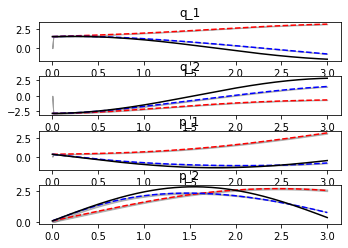

In [24]:

import matplotlib.pyplot as plt
t = np.linspace(0, testing_time, int(testing_time/time_step))
fig, axs = plt.subplots(4)
axs[0].plot(t,evaluate_moi[1][:,0], "--", label="RBF", color="red")
axs[0].plot(t,evaluate_invariance[1][:,0], "--", label="invariance", color="blue")
axs[0].fill_between(t,evaluate_invariance[2][:,0],evaluate_invariance[3][:,0], color="grey", alpha=0.5)
axs[0].fill_between(t,evaluate_moi[2][:,0],evaluate_moi[3][:,0], color="grey", alpha=0.5)
axs[0].plot(t,evaluate_invariance[4][:,0],label="ground truth", color="black")
axs[0].set_title("q_1")

axs[1].plot(t,evaluate_moi[1][:,1], "--", label="RBF", color="red")
axs[1].plot(t,evaluate_invariance[1][:,1], "--", label="invariance", color="blue")
axs[1].fill_between(t,evaluate_invariance[2][:,1],evaluate_invariance[3][:,1], color="grey", alpha=0.5)
axs[1].fill_between(t,evaluate_moi[2][:,1],evaluate_moi[3][:,1], color="grey", alpha=0.5)
axs[1].plot(t,evaluate_invariance[4][:,1],label="ground truth", color="black")
axs[1].set_title("q_2")

axs[2].plot(t,evaluate_moi[1][:,2], "--", label="RBF", color="red")
axs[2].plot(t,evaluate_invariance[1][:,2], "--", label="invariance", color="blue")
axs[2].fill_between(t,evaluate_invariance[2][:,2],evaluate_invariance[3][:,2], color="grey", alpha=0.5)
axs[2].fill_between(t,evaluate_moi[2][:,2],evaluate_moi[3][:,2], color="grey", alpha=0.5)
axs[2].plot(t,evaluate_invariance[4][:,2],label="ground truth", color="black")
axs[2].set_title("p_1")

axs[3].plot(t,evaluate_moi[1][:,3], "--", label="RBF", color="red")
axs[3].plot(t,evaluate_invariance[1][:,3], "--", label="invariance", color="blue")
axs[3].fill_between(t,evaluate_invariance[2][:,3],evaluate_invariance[3][:,3], color="grey", alpha=0.5)
axs[3].fill_between(t,evaluate_moi[2][:,3],evaluate_moi[3][:,3], color="grey", alpha=0.5)
axs[3].plot(t,evaluate_invariance[4][:,3],label="ground truth", color="black")
axs[3].set_title("p_2")

plt.subplots_adjust(left=0.2,
                    bottom=0.2, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.savefig("shm_2d_predicted_trajectory.pdf")
